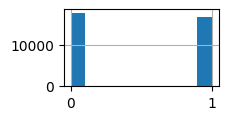

In [9]:
import random
import string
import regex as re
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Opening the csv file without any parsing (UTF-8 encoding by default)
with open("training_data_lowercase.csv", encoding="utf-8") as f:
    lines = f.read().splitlines()

rows = [line.split("\t", 1) for line in lines]
data = pd.DataFrame(rows, columns=["label", "text"])

data["label"] = data["label"].astype(str).str.replace("\ufeff", "", regex=False)
data["label"] = pd.to_numeric(data["label"], errors="coerce").astype("Int64")

test_size = int(len(data)* 0.1)
test_indices = random.sample(range(0, len(data)), test_size)

train_data = data.drop(index=test_indices)
test_data = data.iloc[test_indices]


plt.figure(figsize=(2, 1)) 
plt.xticks([0, 1])
data['label'].hist()
plt.show()

### Data Cleaning and Preprocessing

In [10]:
stemmer = SnowballStemmer(language = 'english')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def clean_html_regex(text: str) -> str:
    # Remove <script>...</script> and <style>...</style> blocks (inline JS/CSS)
    text = re.sub(r'<script.*?>.*?</script>', '', text, flags=re.DOTALL | re.IGNORECASE)
    text = re.sub(r'<style.*?>.*?</style>', '', text, flags=re.DOTALL | re.IGNORECASE)

    # Remove HTML comments <!-- ... -->. # (must be done before removing other tags since comments may contain '>')
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

    # Remove any remaining HTML tags like <div>, <p>, <a href="..."> etc.
    text = re.sub(r'<[^>]+>', '', text)

    # Optional: normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text



def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', ' ', text)             # keep letters, spaces, and !
    text = re.sub(r'\b\w\b', '', text, flags=re.UNICODE)  # remove single-letter words
    text = re.sub(r'\s+', ' ', text).strip()              # collapse multiple spaces
    text = re.sub(r"^b'(.*)'$", r"\1", text)              # remove leading 'b
    text = text.lower()
    return text


def preprocess_text(text):

    text = clean_html_regex(text)
    text = clean_text(text)
    tokens = word_tokenize(text)

    # tokens = [
    #     t
    #     for t in tokens
    #     if t not in stop_words and t not in string.punctuation
    # ]

    # tokens = [
    #     stemmer.stem(t)
    #     for t in tokens
    # ]

    clean_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    #return text
    return clean_tokens


data_train = train_data.copy()
data_test = test_data.copy()

data_train['clean_text'] = data_train['text'].apply(clean_html_regex).apply(clean_text)
data_test['clean_text'] = data_test['text'].apply(clean_html_regex).apply(clean_text)

data_train['tokens'] = data_train['text'].apply(preprocess_text)
data_test['tokens'] = data_test['text'].apply(preprocess_text)

data_train['preprocessed_text'] = data_train['tokens'].apply(lambda x: ' '.join(x))
data_test['preprocessed_text'] = data_test['tokens'].apply (lambda x: ' '.join(x))

data_train.head(2)


,label,text,clean_text,tokens,preprocessed_text
0,0,donald trump sends out embarrassing new year‚s eve message; this is disturbing,donald trump sends out embarrassing new year eve message this is disturbing,"[donald, trump, sends, out, embarrassing, new, year, eve, message, this, is, disturbing]",donald trump sends out embarrassing new year eve message this is disturbing
1,0,drunk bragging trump staffer started russian collusion investigation,drunk bragging trump staffer started russian collusion investigation,"[drunk, bragging, trump, staffer, started, russian, collusion, investigation]",drunk bragging trump staffer started russian collusion investigation


### Bow + Naive Bayes and Logistic Regression

In [11]:

bow_vect = CountVectorizer(max_features=15000, ngram_range=(1,1))

# fit creates one entry for each different word seen
X_bow_train = bow_vect.fit_transform(data_train['preprocessed_text']).toarray()
train_bow_df = pd.DataFrame(X_bow_train,columns=bow_vect.get_feature_names_out())

X_bow_test = bow_vect.transform(data_test['preprocessed_text']).toarray()
test_bow_df = pd.DataFrame(X_bow_test,columns=bow_vect.get_feature_names_out())
#test_bow_df.head(2)

X_train = train_bow_df.copy()
y_train = data_train['label'].copy()

X_test = test_bow_df.copy()
y_test = data_test['label'].copy()

nb_model_bow = MultinomialNB()
nb_model_bow.fit(X_train, y_train)
y_pred = nb_model_bow.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print("BoW Naive Bayes Accuracy Score:", acc)
print("Bow Naive Bayes F1 Score:", f1)

lr_model_bow = LogisticRegression(max_iter=1000, solver='liblinear')
lr_model_bow.fit(X_train, y_train)
y_pred = lr_model_bow.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print("Bow Logistic Regression Accuracy Score:", acc)
print("Bow Logistic Regression F1 Score:", f1)


BoW Naive Bayes Accuracy Score: 0.9452415812591508
Bow Naive Bayes F1 Score: 0.9452253557495881
Bow Logistic Regression Accuracy Score: 0.9443631039531479
Bow Logistic Regression F1 Score: 0.9443749900001187


### TF-IDF + Naive Bayes and Logistic Regression

In [12]:

#tfidf_vectorizer = TfidfVectorizer(max_features=10000, min_df = 10, max_df = 0.5, ngram_range=(1,1))

tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  # Keep top 5000 most important words
    ngram_range=(1, 3),  # Use unigrams and bigrams
    min_df=2,  # Ignore words appearing in fewer than 2 documents
    max_df=0.8  # Ignore words appearing in more than 80% of documents
)


X_tfidf_train = tfidf_vectorizer.fit_transform(data_train['preprocessed_text'])
train_tfidf_df = pd.DataFrame(X_tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


X_tfidf_test = tfidf_vectorizer.transform(data_test['preprocessed_text'])
test_tfidf_df = pd.DataFrame(X_tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


X_train = train_tfidf_df.copy()
y_train = data_train['label'].copy()

X_test = test_tfidf_df.copy()
y_test = data_test['label'].copy()


nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(X_train, y_train)


y_pred = nb_model_tfidf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print("TF-IDF Naive Bayes Accuracy Score:", acc)
print("TF-IDF Naive Bayes F1 Score:", f1)

lr_model_tfidf = LogisticRegression(max_iter=1000, solver='liblinear')
lr_model_tfidf.fit(X_train, y_train)
y_pred = lr_model_tfidf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print("TF-IDF Logistic Regression Accuracy Score:", acc)
print("TF-IDF Logistic Regression F1 Score:", f1)

TF-IDF Naive Bayes Accuracy Score: 0.939385065885798
TF-IDF Naive Bayes F1 Score: 0.9393779670756276
TF-IDF Logistic Regression Accuracy Score: 0.9443631039531479
TF-IDF Logistic Regression F1 Score: 0.9443754765502436


## Sentence Tranformer + Random Forest and XGBoost

In [13]:
from sentence_transformers import SentenceTransformer

#embedder = SentenceTransformer("all-MiniLM-L6-v2")
#embedder = SentenceTransformer("all‑mpnet‑base‑v2")
embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
X_train_mpnet = embedder.encode(data_train["clean_text"].tolist())
X_test_mpnet  = embedder.encode(data_test["clean_text"].tolist())

y_train = data_train["label"]
y_test = data_test["label"]

In [14]:

rf = RandomForestClassifier(
    n_estimators=300,        # number of trees
    max_depth=None,          # let it grow fully
    random_state=42,
    n_jobs=-1                # use all CPU cores
)
rf.fit(X_train_mpnet, y_train)

y_pred = rf.predict(X_test_mpnet)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      1764
         1.0       0.92      0.91      0.92      1651

    accuracy                           0.92      3415
   macro avg       0.92      0.92      0.92      3415
weighted avg       0.92      0.92      0.92      3415

[[1637  127]
 [ 146 1505]]
Accuracy:  0.9200585651537335


In [15]:
import xgboost as xgb
clf = xgb.XGBClassifier(
    n_estimators= 500,
    learning_rate=0.15,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha= 2,
    reg_lambda = 1,
    eval_metric="logloss",
    use_label_encoder=False,
    tree_method="hist",  # for speed
    n_jobs=-1,
    random_state=42
)

clf.fit(X_train_mpnet, y_train)

y_pred = clf.predict(X_test_mpnet)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1764
         1.0       0.95      0.94      0.94      1651

    accuracy                           0.95      3415
   macro avg       0.95      0.95      0.95      3415
weighted avg       0.95      0.95      0.95      3415

[[1685   79]
 [ 105 1546]]
Accuracy:  0.9461200585651537


## Prediction

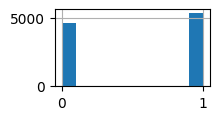

In [17]:
with open("testing_data_lowercase_nolabels.csv", encoding="utf-8") as f:
    final_lines = f.read().splitlines()

final_rows = [line.split("\t", 1) for line in final_lines]
final_data = pd.DataFrame(final_rows, columns=["label", "text"])

final_data['tokens'] = final_data['text'].apply(preprocess_text)
final_data['preprocessed_text'] = final_data['tokens'].apply (lambda x: ' '.join(x))

#bow_vect = CountVectorizer(max_features=10000, ngram_range=(1,2))
X_final_data = bow_vect.transform(final_data['preprocessed_text']).toarray()
final_bow_df = pd.DataFrame(X_final_data, columns = bow_vect.get_feature_names_out())


y_pred_final = lr_model_bow.predict(final_bow_df)
final_data['label'] = y_pred_final

plt.figure(figsize=(2, 1)) 
plt.xticks([0, 1])
final_data['label'].hist()
plt.show()

final_data= final_data[['label','text']]

final_data.to_csv("testing_data_lowercase_results.csv")
